# STL RNN

The goal of this notebook is to convert the char RNN example from the rnn_examples notebook into one that can process STL files.

Unfortunately, reusing code from the rnn_examples notebook did not work out as well as hoped. It did, however, serve as a quality learning exercise. The rnn_examples model is based on discrete input: language where each word is an indexed token. That leads to problems with our model as our input is continuous: each stl file has vertices that can be any real number.

After a continuous example was located, our luck improved: https://github.com/subpath/Keras_music_gereration/blob/master/Music%20gerenation%20with%20Keras%20and%20TF.ipynb

## Setup

In [1]:
# setup
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import os
import time

# autoreload changed modules!!
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

## Data

An RNN processes data sequentially and is able to maintain an understanding of the __context__ between the current input and the last _M_ inputs.

When this concept is applied to STL files, we want the RNN to understand that triangle $T_{i}$ must share vertices with triangle $T_{i-1}$. 

Therefore, we will form our input to be 2d matrices of triangles. Each input will be a vector of shape

$$ [ x_1, y_1, z_1, x_2, y_2, z_2, x_3, y_3, z_3 ] $$

An alternate approach is to use vertices as our input. This would have a shape of

$$ [ x, y, z ] $$

Both of the above make a powerful assumption: the vertices in the STL file are in order (i.e. triangle $T_{i}$ is next to  triangle $T_{i-1}$ in the STL file). A cursory glance of several STL files confirm that the triangles are in order, but a lengthier EDA of this assumption is recommended.

In [2]:
import env
from data.thingi10k import Thingi10k
from models import MODEL_DIR

thingi = Thingi10k.init10()
n_samples = len(thingi)
print('n_samples: ', n_samples)
print('num_triangles: ', thingi.num_triangles())

n_samples:  10
num_triangles:  69734


In [36]:
# jumping in to throw out TF's dataset API; it is not working as expected
# we want our data to be the shape of (batch_size, seq_length, 9) for triangles
BATCH_SIZE = 9*50
SEQ_LENGTH = 9*90
WINDOW_SIZE = 9*30  # num triangles
#UNIT_SIZE = 9  # triangle prediction
UNIT_SIZE = 1  # vertex prediction

X = list()
Y = list()
for seq in thingi.triangle_sequencer(SEQ_LENGTH):
    for i in range(len(seq) - WINDOW_SIZE):
        x = seq[i:i+WINDOW_SIZE]
        y = seq[i+WINDOW_SIZE]
        X.append(x)
        Y.append(y)
        
X = np.asarray(X)
Y = np.asarray(Y)

# the idea is that given triangle sequence X, predict the next triangle
# Y is the array that holds the next triangle
# and each triangle sequence X is the same as the previous *plus one index*
# so, X[1][-1] == Y[0]
print(X.shape)
print(Y.shape)
assert np.array_equal(X[1][-1], Y[0])

#dataset = zip(X, Y)

# what if you want to do by vertex and not by triangle?
X = np.reshape(X, (-1, WINDOW_SIZE, 1))
Y = np.reshape(Y, (-1, 1))
print(X.shape)
print(Y.shape)

(49680, 270, 9)
(49680, 9)
(447120, 270, 1)
(447120, 1)


## Build The Model

In [37]:
def build_model(window_size, unit_size):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(256, input_shape=(window_size, unit_size), return_sequences=True),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.LSTM(128, input_shape=(window_size, unit_size), return_sequences=True),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.LSTM(64, input_shape=(window_size, unit_size), return_sequences=False),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(unit_size),
        tf.keras.layers.Activation('linear')
    ], name='stl-lstm')
    return model

In [38]:
model = build_model(window_size=WINDOW_SIZE, unit_size=UNIT_SIZE)
optimizer = tf.train.AdamOptimizer()
model.compile(loss='mse', optimizer=optimizer)
os.makedirs(os.path.join(MODEL_DIR, 'stl_rnn', "Checkpoints"), exist_ok=True)
filepath = os.path.join(MODEL_DIR, 'stl_rnn', "Checkpoints/checkpoint_model_{epoch:02d}.hdf5")
model_save_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', 
                                      verbose=1, save_best_only=False, 
                                      mode='auto', period=5)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 270, 256)          264192    
_________________________________________________________________
dropout_6 (Dropout)          (None, 270, 256)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 270, 128)          197120    
_________________________________________________________________
dropout_7 (Dropout)          (None, 270, 128)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
__________

## Try The Model

In [ ]:
model.fit(X, Y, batch_size=64, epochs=3, verbose=1, callbacks=[model_save_callback])

Epoch 1/3
1782/6987 [======>.......................] - ETA: 12:15:36 - loss: 0.0400

## Make A Prediction

In [19]:
seed = X[0]
seed.shape

(72, 1)

In [25]:
prediction = []
x = np.expand_dims(seed, axis=0)

print_every = 1000
last_pred = None
new_preds = 0
for i in range(5000):
    preds = model.predict(x)
    x = np.squeeze(x)
    x = np.reshape(x, (-1, 1))
    x = np.concatenate((x, preds))
    x = x[1:]
    x = np.expand_dims(x, axis=0)
    preds = np.squeeze(preds)
    if not np.array_equal(preds, last_pred):
        #print('Prediction {}: it made something new!'.format(i))
        #print('last: ', last_pred)
        #print('new: ', preds)
        new_preds += 1
    last_pred = preds
    prediction.append(preds)
    if i % print_every == 0:
        print('Prediction {}: {}'.format(i, preds))

print('new_preds: {}'.format(new_preds))

# rnn producing same predictions?
#
# https://datascience.stackexchange.com/questions/20442/recurrent-neural-network-producing-same-predictions
# recommends increasing the batch size
#
# https://stackoverflow.com/questions/47125723/keras-lstm-for-text-generation-keeps-repeating-a-line-or-a-sequence
# recommends increasing sequence length

Prediction 0: 0.5526803731918335
Prediction 1000: 0.6259970664978027
Prediction 2000: 0.6259970664978027
Prediction 3000: 0.6259970664978027
Prediction 4000: 0.6259970664978027
new_preds: 173


In [29]:
vectors = thingi._reform_vectors(np.asarray(prediction[:-5]))
vectors.shape

(5000,)


(555, 3, 3)

In [33]:
# any coordinates out of bounds?
oob = 0
for v in vectors:
    if v.min() < 0 or v.max() > 1:
        oob += 1
        print(v)
        break
oob


0

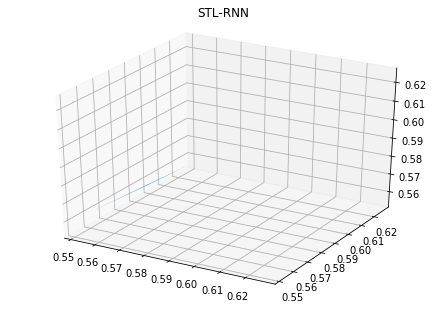

In [35]:
from data.stl import plot_mesh


plot_mesh(vectors, title='STL-RNN')


In [138]:
from data.stl import save_vectors_as_stl
save_vectors_as_stl(vectors, 'first_rnn_stl.stl')